### Solving an  Ordinary Differential Equations (ODE)   with a neural network

# Goals of the PW

  Solving an ODE with a neural network

Nowadays,  [automatic differentiation] https://arxiv.org/abs/1502.05767 makes it possible to approach calculus problems from a machine learning perspective. Maybe you’ve heard some of the buzz around the [Neural Ordinary Differential Equations] https://arxiv.org/abs/1806.07366 paper at NIPS 2018, which was presented https://www.youtube.com/watch?v=V6nGT0Gakyg by David Duvenaud, one of the authors Autograd. Meanwhile, Autograd has been superseded by JAX https://github.com/google/jax, which is what we will be using here.

The main problem is as follows: we want to find an unknown function y=f(x) which is defined by a differential equation, for example, $y'=-2xy$, together with some initial conditions, such as $y(0)=1$. The example comes from the first few pages of Kreyszig’s Advanced Engineering Mathematics https://www.amazon.com/Advanced-Engineering-Mathematics-Erwin-Kreyszig/dp/0471553808/. The analytical solution to this particular initial value problem is $y=exp(-x^2)$, which we will use to verify the results provided by the neural network.

In general, there might not be a closed-form solution to the ODE, but it is possible to approximate the unknown function $y=f(x)$ with a neural network. To keep it simple, we will solve the problem $y'=-2xy$ and $y(0)=1$ with a neural network having a single hidden layer with 10 nodes.

Here is a diagram for our neural net: https://www.juripredis.com/fr/blog/id-19-demystifier-le-machine-learning-partie-2-les-reseaux-de-neurones-artificiels

>  https://www.ibm.com/cloud/learn/neural-networks








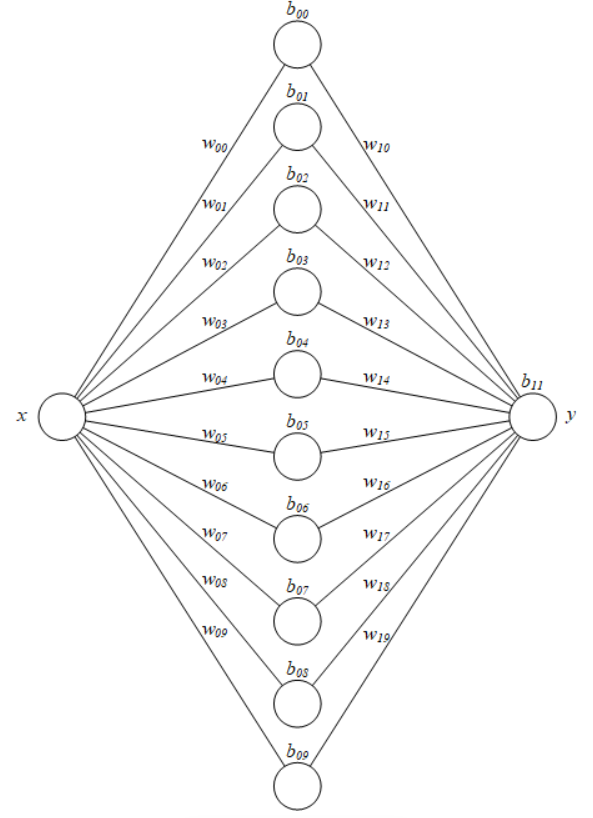

In total, the network has 31 trainable parameters: the weights and biases for the hidden layer, plus the weights and bias for the output layer.

In [54]:
#!pip install pip==20.2.4
#!pip install --upgrade jax==0.3.2 jaxlib==0.3.2+cuda11.cudnn82 -f https://storage.googleapis.com/jax-releases/jax_releases.html
#!pip install https://storage.googleapis.com/jax-releases/cuda11/jaxlib-0.1.76+cuda11.cudnn82-cp39-none-manylinux2010_x86_64.whl

JAX https://fr.quish.tv/getting-started-with-jax-mlps

https://jax.readthedocs.io/en/latest/notebooks/quickstart.html

# Exercise: Implement the network given bellow


In [42]:
import jax.numpy as np
from jax import random

In [43]:
def activation_function(x):
    return 1./(1. + np.exp(-x))
def neurone(x, list_params):
    w0 = list_params[:10] #weight initial
    b0 = list_params[10:20] #bias initial
    w1 = list_params[20:30] # weight hide layer
    b1 = list_params[30] #bias hide layer
    x1 = activation_function(x*w0 + b0)
    output = activation_function(np.sum(x1*w1) + b1)
    return output

# Solution 

Let’s implement the network as follows:

where we use the JAX NumPy-like API so that, later on, we can calculate the derivatives of f through automatic differentiation. Note that f has two arguments: an array of network parameters (params), and an input value (x). While in machine learning we usually differentiate a model with respect to its parameters, here we will also be differentiating f with respect to x in order to solve the ODE.

The network parameters can be initialized randomly, for example using a normal distribution:

where we use the pseudo-random number generator (PRNG) provided by JAX. By creating a PRNG key with a certain seed, we ensure that our results will be reproducible.

Exercise : Write the derivative of f with respect to x 

# Soluton 

In [13]:
from jax import grad

dfdx = grad(f, 1)

The derivative of f with respect to x can be obtained with a call to grad:

In [4]:
from jax import grad

dfdx = grad(f, 1)

where 1 means that we want the gradient of f with respect to its second argument x (zero-based indexing). In JAX, grad returns a function that evaluates the gradient of f and has the same arguments as the original f.

Now, we will want to solve the ODE in a certain domain, for example in $-2 ≤ x ≤ 2$. Therefore, we create an array of input values in that range:

In [19]:
inputs = np.linspace(-10., 10., num=1000)



In [21]:
inputs

DeviceArray([-10.        ,  -9.9799795 ,  -9.95996   ,  -9.9399395 ,
              -9.91992   ,  -9.8998995 ,  -9.87988   ,  -9.859859  ,
              -9.83984   ,  -9.819819  ,  -9.7998    ,  -9.779779  ,
              -9.75976   ,  -9.739739  ,  -9.71972   ,  -9.699699  ,
              -9.67968   ,  -9.659659  ,  -9.63964   ,  -9.619619  ,
              -9.5996    ,  -9.579579  ,  -9.55956   ,  -9.539539  ,
              -9.51952   ,  -9.499499  ,  -9.47948   ,  -9.459459  ,
              -9.43944   ,  -9.419419  ,  -9.3994    ,  -9.379379  ,
              -9.35936   ,  -9.339339  ,  -9.31932   ,  -9.299299  ,
              -9.27928   ,  -9.259259  ,  -9.23924   ,  -9.219219  ,
              -9.1992    ,  -9.179179  ,  -9.15916   ,  -9.139139  ,
              -9.11912   ,  -9.099099  ,  -9.07908   ,  -9.059059  ,
              -9.03904   ,  -9.019019  ,  -8.999     ,  -8.978979  ,
              -8.958959  ,  -8.938939  ,  -8.918919  ,  -8.898899  ,
              -8.878879  ,  -8.858

where 401 points is an arbitrary choice to have a resolution of 0.01 in the interval $[-2, 2]$.

However, f accepts a single value x as input. We could pass it an array but, for differentiation purposes, JAX requires a scalar function, so we must pass a single value as input in order to get a single value as output. To efficiently compute f and its derivative dfdx for an array of input values, we vectorize those functions using vmap:

In [15]:
from jax import vmap

f_vect = vmap(f, (None, 0))
dfdx_vect = vmap(dfdx, (None, 0))

where (None, 0) specifies that each function is to be mapped over the 0-axis of the second argument (x), while the first argument (params) should be left untouched (with None, it will be broadcasted across the mapping).

We can now define our loss function (yes, the loss function that appears in any machine learning project, and whose minimization will yield our desired solution):

> 



### Solution

In [ ]:
#error function
from jax import jit
def loss(params, inputs):
    eq = dfdx_vect(params, inputs) + 2.*inputs*f_vect(params, inputs)
    ic = f(params, 0.) - 1.
    return np.mean(eq**2) + ic**2

In [7]:
#Solution 
from jax import jit

@jit
def loss(params, inputs):
    eq = dfdx_vect(params, inputs) + 2.*inputs*f_vect(params, inputs)
    ic = f(params, 0.) - 1.
    return np.mean(eq**2) + ic**2

Note how the differential equation y’=-2xy and the initial condition y(0)=1 have been captured in eq and ic, respectively. They have been expressed as y’+2xy=0 and y(0)-1=0 in order to minimize the residuals y’+2xy and y(0)-1 during the training process. We use JIT (just-in-time compilation) on this function to speed up its execution on accelerator hardware, such as a GPU or a TPU, if available.

As with any machine learning project, we now differentiate the loss function with respect to the trainable parameters:

In [8]:
grad_loss = jit(grad(loss, 0))

where 0 means that we want the gradient of the loss function with respect to its first argument (params). Again, we use JIT to speed up the execution of this new function.

It’s time to start training! To accelerate things a bit, we will use gradient descent with Nesterov momentum. Recall the formula for Nesterov Accelerated Gradient (NAG):

$$ \begin{eqnarray} 
v_{t+1} &= \mu v_t - \epsilon \nabla f(\theta_t+ \mu v_t) \\
\theta_{t+1}&= \theta_t+ v_{t+1}
\end{eqnarray}
$$

We therefore implement the training process as follows:

In [9]:
epochs = 1000
learning_rate = 0.1
momentum = 0.99
velocity = 0.

for epoch in range(epochs):
    if epoch % 100 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss(params, inputs)))
    gradient = grad_loss(params + momentum*velocity, inputs)
    velocity = momentum*velocity - learning_rate*gradient
    params += velocity

epoch:   0 loss: 0.954726
epoch: 100 loss: 0.061131
epoch: 200 loss: 0.024128
epoch: 300 loss: 0.008868
epoch: 400 loss: 0.003202
epoch: 500 loss: 0.001567
epoch: 600 loss: 0.000880
epoch: 700 loss: 0.000505
epoch: 800 loss: 0.000306
epoch: 900 loss: 0.000224


Finally, let’s plot the results and compare to the analytical solution:

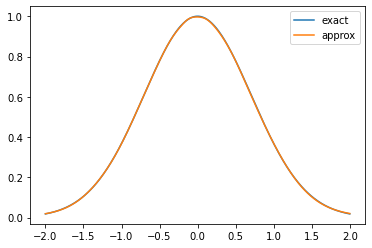

In [10]:
import matplotlib.pyplot as plt

plt.plot(inputs, np.exp(-inputs**2), label='exact')
plt.plot(inputs, f_vect(params, inputs), label='approx')
plt.legend()
plt.show()

There we go, the neural network approximation looks practically indistinguishable from the exact, analytical solution.

One final question: what happens outside the domain [-2, 2] of approximation? 

# Application: Solve the following equation using the neural network  on $[-3,3]$
 $$
 \begin{eqnarray*}
  y' &=  3 x^2 y \\
 y(1) &= 2
 \end{eqnarray*}$$

In [64]:
f_vect = vmap(neurone, (0, None))
dfdx_vect = vmap(dfdx, (0, None))

In [69]:
def loss(params, inputs):
    eq = dfdx_vect(inputs, inputs) - (3.*(inputs**2)*f_vect(inputs, params))
    ic = neurone(1., params) - 2.
    return np.mean(eq**2) + ic**2

In [70]:


key = random.PRNGKey(0)
params = random.normal(key, shape=(31,))

dfdx = grad(neurone, 1)
inputs = np.linspace(-3., 3., num=1000)

f_vect = vmap(neurone, (0, None))
dfdx_vect = vmap(dfdx, (0, None))

grad_loss = jit(grad(loss, 0))

In [71]:
inputs

DeviceArray([-3.        , -2.993994  , -2.987988  , -2.981982  ,
             -2.975976  , -2.96997   , -2.963964  , -2.957958  ,
             -2.951952  , -2.945946  , -2.93994   , -2.933934  ,
             -2.927928  , -2.921922  , -2.915916  , -2.90991   ,
             -2.903904  , -2.897898  , -2.891892  , -2.885886  ,
             -2.87988   , -2.873874  , -2.867868  , -2.861862  ,
             -2.855856  , -2.84985   , -2.843844  , -2.837838  ,
             -2.831832  , -2.825826  , -2.81982   , -2.813814  ,
             -2.807808  , -2.801802  , -2.795796  , -2.78979   ,
             -2.783784  , -2.777778  , -2.771772  , -2.765766  ,
             -2.75976   , -2.753754  , -2.747748  , -2.741742  ,
             -2.735736  , -2.72973   , -2.723724  , -2.717718  ,
             -2.711712  , -2.705706  , -2.6996999 , -2.6936939 ,
             -2.6876876 , -2.6816816 , -2.6756756 , -2.6696696 ,
             -2.6636636 , -2.6576576 , -2.6516516 , -2.6456456 ,
             -2.6396396 ,

In [76]:
epochs = 1000
learning_rate = 0.1
momentum = 0.99
velocity = 0.

for epoch in range(epochs):
    if epoch % 100 == 0:
        print('epoch: %3d loss: %.6f' % (epoch, loss(params, inputs)))
    gradient = grad_loss(params + momentum*velocity, inputs)
    velocity = momentum*velocity - learning_rate*gradient
    params += velocity

epoch:   0 loss: nan
epoch: 100 loss: nan
epoch: 200 loss: nan
epoch: 300 loss: nan
epoch: 400 loss: nan
epoch: 500 loss: nan
epoch: 600 loss: nan
epoch: 700 loss: nan
epoch: 800 loss: nan
epoch: 900 loss: nan


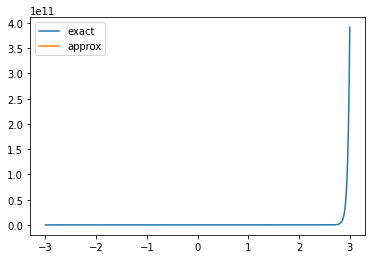

In [78]:
plt.plot(inputs, (2*np.exp(inputs**3))/np.exp(1), label='exact')
plt.plot(inputs, f_vect(inputs,params), label='approx')
plt.legend()
plt.show()

In [75]:
f_vect(inputs, params)

DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan